In [1]:
import os,sys
import glob
import pandas
from osgeo import gdal
import datetime 
from dateutil import parser
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import stackConfigs as sC

## Go to vertex and do an initial search
You should narrow down your area of interest, and which track you are using. Choose a bounding box (draw on map) - all frames that even touch it will be downloaded, so take some care in choosing a reasonable bounds
Paste in the "wkt" format lat/lon bounds from vertex, and set the relevant information in stackConfigs.py

## Run api calls to construct list of files

In [2]:
#this is a dumb way of doing this, but I don't feel like dealing with installing the requests package.
apistring='https://api.daac.asf.alaska.edu/services/search/param?platform=S1&polarization=VV%2BVH&beamSwath=IW&processingLevel=SLC'+sC.track+sC.date1+sC.date2+sC.polygon
os.system('wget \"'+apistring+'&output=csv\" -O '+sC.workdir+'/list.csv -q')
# this gives api that can be searched as url for list of files using different output types
print(apistring)
# to search this api, copy the apistring and add "&output=count" for output as a count


https://api.daac.asf.alaska.edu/services/search/param?platform=S1&polarization=VV%2BVH&beamSwath=IW&processingLevel=SLC&relativeOrbit=173&start=2017-05-10&end=2022-01-10&intersectsWith=POLYGON((-116.0339 31.7594,-115.1386 31.7594,-115.1386 32.7782,-116.0339 32.7782,-116.0339 31.7594))


In [3]:
df = pandas.read_csv(sC.workdir+'/list.csv')
df['Acquisition Date'] = pandas.to_datetime(df['Acquisition Date'])
df['date'] = pandas.to_datetime(df['Acquisition Date'])    
numfiles = np.shape(df)[0]
print(numfiles)
uniqueDates=df['date'].dt.date.unique()
uniqueDates.sort()

totNumDates=np.size(uniqueDates)
uniqueDateStr=[]
for i in np.arange(totNumDates):
    uniqueDateStr.append(uniqueDates[i].strftime('%Y%m%d'))

print(str(totNumDates)+ ' unique dates and ' + str(numfiles) +' total files')

coregSLCDir = os.path.join(sC.workdir, 'coreg_secondarys/vv') #look in vv since that should be complete
if os.path.exists(coregSLCDir):
    coregSecondarys = glob.glob(os.path.join(coregSLCDir, '[0-9]???[0-9]?[0-9]?'))
    coregSLC = [os.path.basename(slv) for slv in coregSecondarys]
    coregSLC.sort()

    if len(coregSLC)>0:
        print('It looks like the following dates have already been done')
        print(coregSLC)
        remNumDates = totNumDates-len(coregSLC)
        
    else:
        remNumDates = totNumDates

else:
    coregSLC = []
    remNumDates = totNumDates


newDates = np.setdiff1d(uniqueDateStr,coregSLC)

print(str(remNumDates)+' dates still to process, length of newDates='+str(newDates.size))
print(newDates)
batches = int(np.ceil(remNumDates / sC.targetNumDates))
print(str(batches)+' batches based on '+str(sC.targetNumDates)+ ' dates/batch')
print('Next date would be '+str(newDates[0]))


422
212 unique dates and 422 total files
It looks like the following dates have already been done
['20170510', '20170522', '20170603', '20170615', '20170627']
207 dates still to process, length of newDates=207
['20170709' '20170721' '20170802' '20170814' '20170826' '20170907'
 '20170919' '20171013' '20171025' '20171106' '20171118' '20171130'
 '20171212' '20171224' '20180105' '20180117' '20180129' '20180210'
 '20180222' '20180306' '20180318' '20180330' '20180411' '20180423'
 '20180505' '20180517' '20180529' '20180610' '20180622' '20180704'
 '20180716' '20180728' '20180809' '20180821' '20180902' '20180914'
 '20180926' '20181008' '20181020' '20181101' '20181113' '20181125'
 '20181207' '20181219' '20181231' '20190112' '20190124' '20190205'
 '20190217' '20190301' '20190313' '20190325' '20190406' '20190430'
 '20190512' '20190524' '20190605' '20190617' '20190629' '20190711'
 '20190723' '20190804' '20190816' '20190822' '20190828' '20190903'
 '20190909' '20190915' '20190921' '20190927' '2019100

## First batch
Now we have a list of files so we will try our first batch, which should contain your first (reference) date as set above.  I think this SHOULD now find all files on a given date.  That part was a pain.

In [4]:
i=0
index=0
print('Downloading data for batch '+str(int(i)))
for j in np.arange(sC.targetNumDates):
    if index < remNumDates:
        for k in np.arange(numfiles):
            if df.date[k].strftime('%Y%m%d') == newDates[index]:
                    rawFile=df['URL'][k]
                    rawRoot=os.path.basename(rawFile)
                    if os.path.exists(os.path.join('/home/jovyan',sC.workdir,'raw',rawRoot)):
                        print(rawRoot+' already downloaded')
                    else:
                        print('Downloading '+rawRoot)
                        wstr='wget '+ rawFile + ' --directory-prefix=' + sC.workdir + '/raw'
                        os.system(wstr+' -q  --show-progress  --progress=bar:force:noscroll')
        
        index+=1
    

## prepping and running stack

In [5]:
command='stackSentinel_VH.py -s '+sC.workdir+'/raw -m '+sC.refdate+' -o /home/jovyan/ -a '+sC.workdir+'/aux/ -w '+sC.workdir+' -d '+sC.dem+sC.narrowpoly+sC.swaths+sC.looks+' -c 1 -O 1 -W interferogram'
print(command)
os.system(command)

stackSentinel_VH.py -s LagunaSalada/raw -m 20170510 -o /home/jovyan/ -a LagunaSalada/aux/ -w LagunaSalada -d /home/jovyan/LagunaSalada/DEM/demLat_N31_N33_Lon_W117_W115.dem.wgs84 -b '32.29 32.75 -116.0 -115.15'  -n '1 2 3' -r 20 -z 4  -c 1 -O 1 -W interferogram


## Check output 
Did it run and make run_files and runstuff and runstuff2?  Did all the dates get selected?  often need to adjust the -b parameter here.

## Next, run the "runstuff" command that runs all the subroutines making the stack

In [10]:
os.system(sC.workdir+'/runstuff  > errors 2> extraerrors')

0

## Check output
Did everything run?  Is there content in the merged directory?  If so, now is the time to pick your cropping locations.

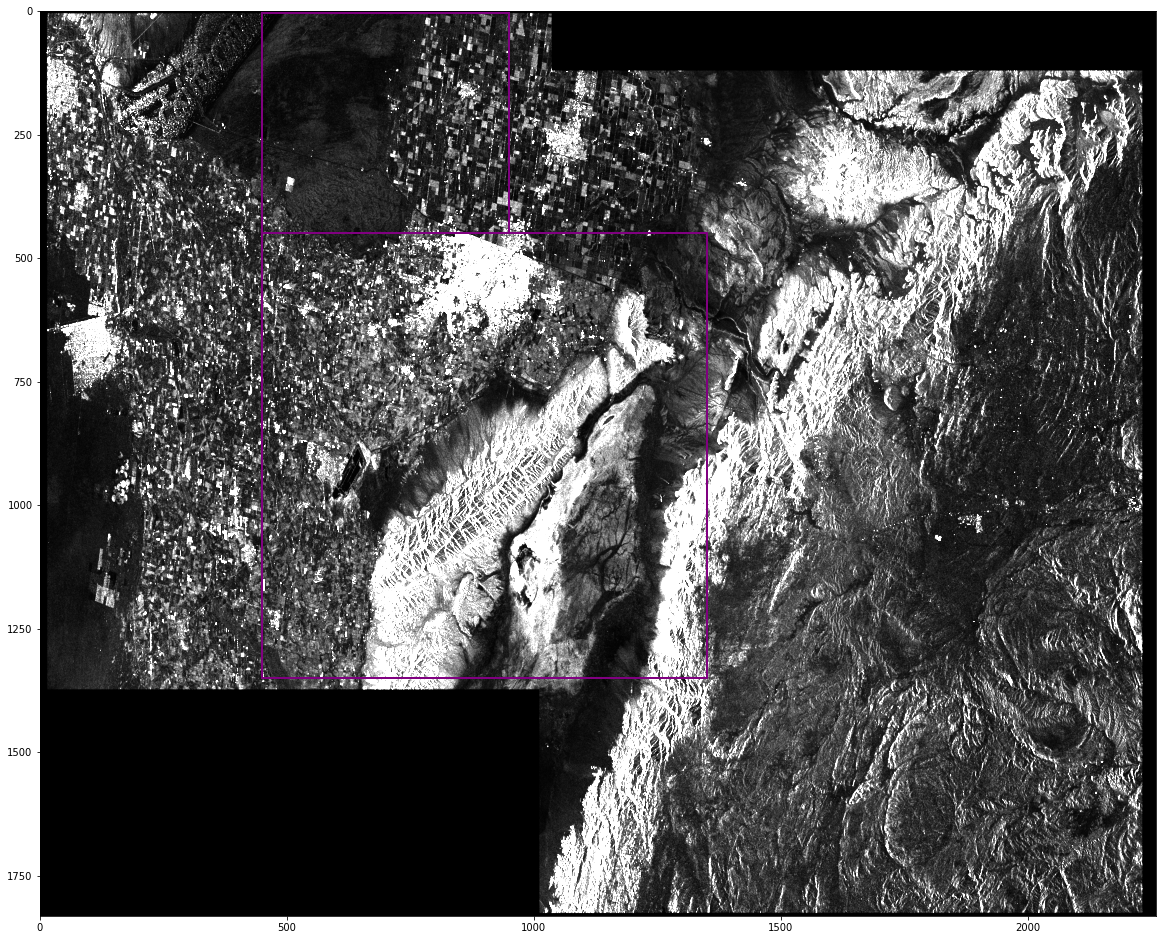

In [6]:
ds = gdal.Open("/home/jovyan/"+sC.workdir+"/merged/interferograms/"+sC.pltdate+"/fine.int", gdal.GA_ReadOnly)
data_array = ds.GetRasterBand(1).ReadAsArray()

ang_data_array= np.angle(data_array)
abs_data_array= np.abs(data_array)

plt.figure(figsize=(20, 22))
#plt.imshow(ang_data_array,vmin=-np.pi, vmax=np.pi, cmap='jet')
plt.imshow(abs_data_array,vmin=0, vmax=10000, cmap='gray')

#now loop over polygons
for i in np.arange(sC.croppoly.shape[0]):
    #bounds of our cropped region
    x1=int(sC.croppoly[i,0]/sC.rlooks)
    x2=int((sC.croppoly[i,0]+sC.croppoly[i,2])/sC.rlooks)
    y1=int(sC.croppoly[i,1]/sC.alooks)
    y2=int((sC.croppoly[i,1]+sC.croppoly[i,3])/sC.alooks)


    rect=mpatches.Rectangle((x1,y1),(x2-x1),(y2-y1), 
                        fill=False,
                        color="purple",
                       linewidth=2)
                       #facecolor="red")
    plt.gca().add_patch(rect)


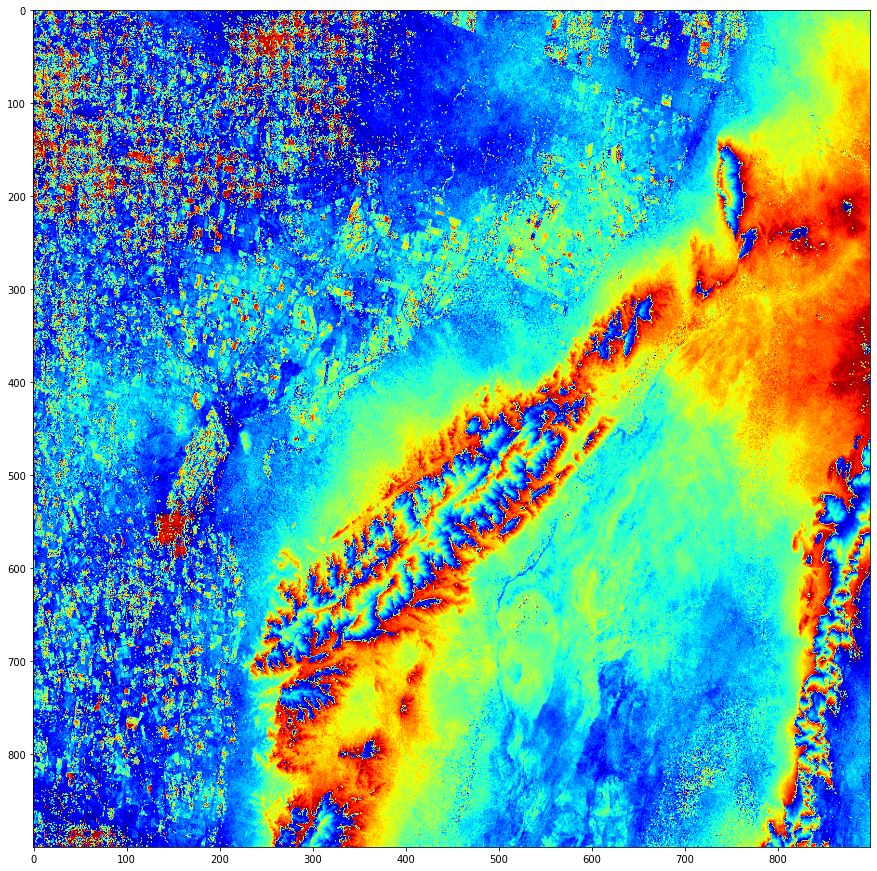

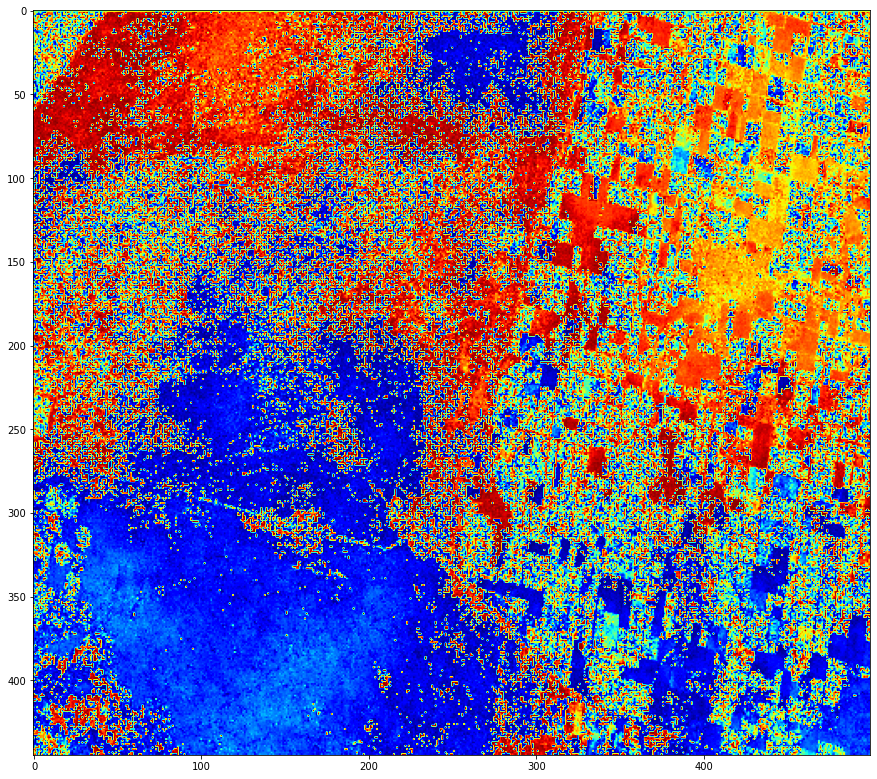

In [7]:
#loop over polygons again
for i in np.arange(sC.croppoly.shape[0]):
    #bounds of our cropped region
    x1=int(sC.croppoly[i,0]/sC.rlooks)
    x2=int((sC.croppoly[i,0]+sC.croppoly[i,2])/sC.rlooks)
    y1=int(sC.croppoly[i,1]/sC.alooks)
    y2=int((sC.croppoly[i,1]+sC.croppoly[i,3])/sC.alooks)


    plt.figure(figsize=(15, 16))
    plt.imshow(ang_data_array[y1:y2,x1:x2],vmin=-np.pi, vmax=np.pi, cmap='jet')
    #plt.imshow(abs_data_array[y1:y2,x1:x2],vmin=0, vmax=10000, cmap='gray')


## Crop and delete
Next we run runstuff 2 - be careful, since what it does is crop and then delete files!

In [18]:
os.system(sC.workdir+'/runstuff2')


cropping /home/jovyan/LagunaSalada/merged/SLC_vv/20210302/20210302.slc.full
cropping /home/jovyan/LagunaSalada/merged/SLC_vv/20201226/20201226.slc.full
cropping /home/jovyan/LagunaSalada/merged/SLC_vv/20210101/20210101.slc.full
cropping /home/jovyan/LagunaSalada/merged/SLC_vh/20210302/20210302.slc.full
cropping /home/jovyan/LagunaSalada/merged/SLC_vh/20201226/20201226.slc.full
cropping /home/jovyan/LagunaSalada/merged/geom_reference/lon.rdr.full
cropping /home/jovyan/LagunaSalada/merged/geom_reference/lat.rdr.full
cropping /home/jovyan/LagunaSalada/merged/geom_reference/los.rdr.full
cropping /home/jovyan/LagunaSalada/merged/geom_reference/hgt.rdr.full
cropping /home/jovyan/LagunaSalada/merged/SLC_vv/20210302/20210302.slc.full
cropping /home/jovyan/LagunaSalada/merged/SLC_vv/20201226/20201226.slc.full
cropping /home/jovyan/LagunaSalada/merged/SLC_vv/20210101/20210101.slc.full
cropping /home/jovyan/LagunaSalada/merged/SLC_vh/20210302/20210302.slc.full
cropping /home/jovyan/LagunaSalada/m

0